# Aprendizaje automático de principio a fin - Preprocesado de datos

En este notebook continuaremos con el dataset habitacional de California, con el que ya hemos hecho un AED básico. Nos centraremos en todo lo relacionado al preprocesado de datos. En las siguientes clases vamos a empezar a trabajar con algunos modelos y aprender a evaluar su performance.

## El problema

Si bien la idea hoy no es aprender a entrenar/ajustar un modelo, para ponernos un objetivo concreto en esta clase vamos a intentar predecir el *Median House Value* del dataset de California a partir del resto de las variables disponibles usando un modelo lineal. En este caso, y a lo largo del curso, no vamos a tener que preocuparnos por la extracción de los datos, ya que alguien ya hizo el trabajo por nosotros (ya disponemos del dataset). Así que procedamos a cargarlos. 

## Importación y bajada de datos

Definimos la ruta de los datos e importamos.

In [ ]:
# Se requiere Python ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥ 0.20
import sklearn as sk
assert sk.__version__ >= "0.20"

# Módulos comunes
import numpy as np
import pandas as pd
import os

# Para hacer gráficos bonitos en el notebook
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Donde guardar figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "S4_Preprocesado"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Guarda las figuras en la carpeta que le especificamos antes"""
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Para ignorar algunos warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Descargamos la imagen de California 
!wget "https://raw.githubusercontent.com/ageron/handson-ml2/master/images/end_to_end_project/california.png" -P {IMAGES_PATH}


HOUSING_PATH = "datasets"
def load_housing_data(housing_path=HOUSING_PATH):
  """Función para leer el dataset"""
  csv_path = os.path.join(housing_path, "housing_mod.csv")
  return pd.read_csv(csv_path)

Correr la siguiente celda para bajar el dataset:

In [ ]:
if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://github.com/IAI-UNSAM/datasets/raw/master/housing/"
    HOUSING_URL = DOWNLOAD_ROOT + "housing.tgz"

    !mkdir -p ./datasets/housing

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        #urllib.request.urlretrieve(housing_url, tgz_path)
        !wget {HOUSING_URL} -P {housing_path}
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

    # Corramos la función
    fetch_housing_data()

else: 
    print("No están corriendo en Google Colab. Esta celda no hace nada.")

La próxima celda levanta los datos en la variable `housing`

In [ ]:
housing = load_housing_data()

## AED + Marco del problema

En la última sesión terminamos con un gráfico bonito como este

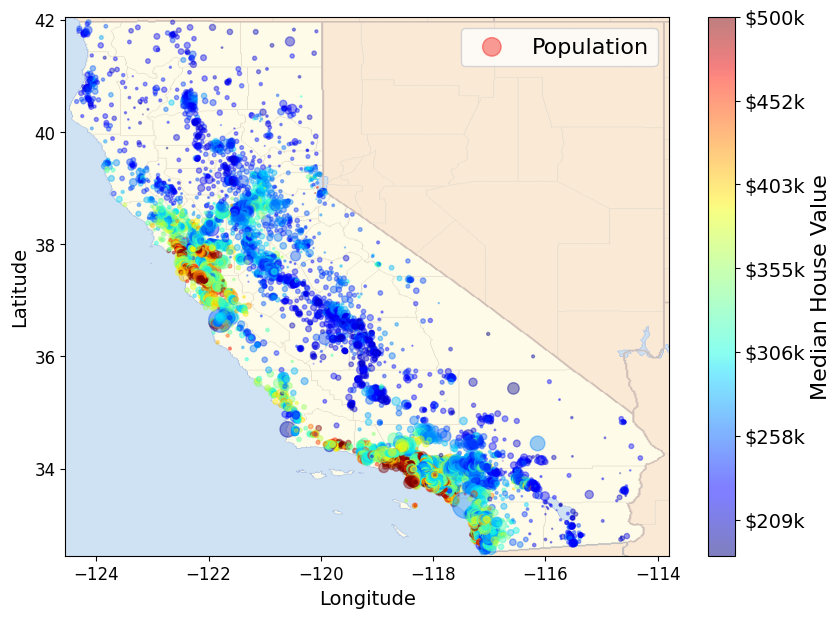

In [ ]:
california_img=mpl.image.imread(os.path.join(IMAGES_PATH, "california.png"))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
plt.show()

Con esta información podemos decidir qué tipo de modelo queremos desarrollar, es decir qué *sistema inteligente* vamos a diseñar que haga uso de estos datos. 

Como ya dijimos, nos enfocaremos en predecir el *Median House Value* de un dado distrito (este será nuestro **OBJETIVO**), basado en los atributos presentes en el dataset (estas serán nuestras **VARIABLES**). 

Un aspecto relevante es el *tipo* de variable que queremos predecir. Nuestra variable objetivo es *continua*, un número real (o un número tipo *float* en la computadora). Esto va a resultar importante a la hora de elegir los modelos con los que vamos a trabajar.

En esta celda, separamos la varible objetivo de las demas (usando el método `drop`), y les cambiamos los nombres por simplicidad.

In [ ]:
# Definimos el nombre de la variable target (objetivo)

target_column_name = 'median_house_value'

X = housing.drop(target_column_name, axis=1) # features (características)
y = housing[target_column_name] # target (objetivo)

## Ingeniería de *features* (Feature Engineering)

Como queremos predecir el `'median_house_value'`, en general nos van a interesar aquellas variables del dateset que estén más correlacionadas con ella. Una manera rápida de ver la correlación entre variables (features) es con un scatterplot. 

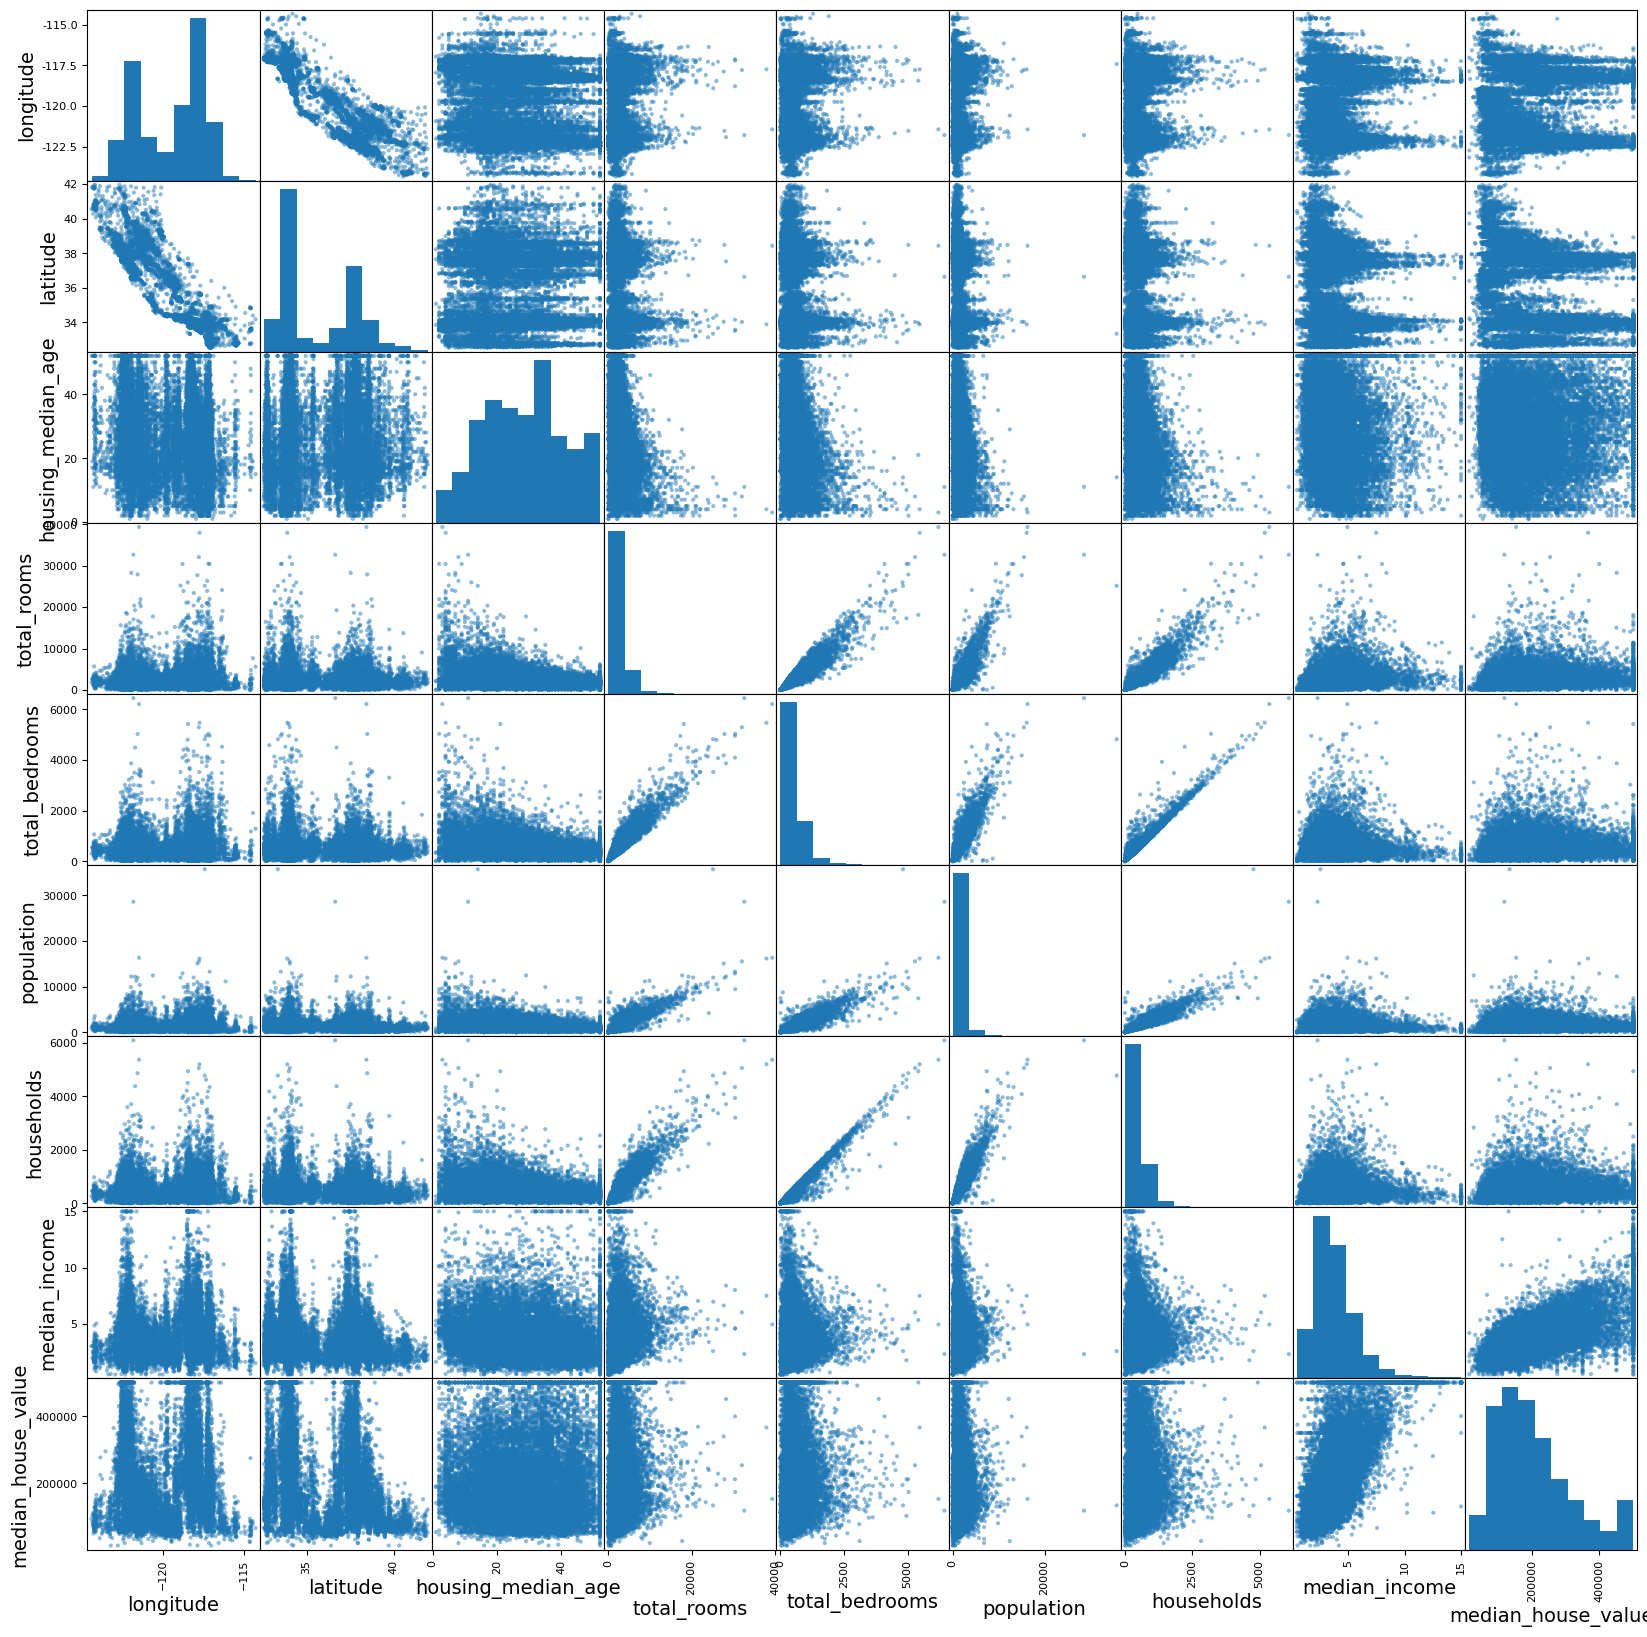

In [ ]:
pd.plotting.scatter_matrix(housing, figsize=(20,20))
plt.show()

Notar que la última columna/fila muestra la correlación entre alguna variable y nuestro objetivo. Si quisieramos ser más cuantitativos podemos usar el método `corrwith(target)` de los dataframes de Pandas. Se puede tomar el valor absoluto de la correlación , y ordenar de manera descendente para encontrar rapidamente las feratures más importantes.

In [ ]:
df_corr = abs(X.corrwith(y))
df_corr.sort_values(ascending=False)

<ipython-input-7-f7e9b8e3707d>:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = abs(X.corrwith(y))


median_income         0.688075
latitude              0.144160
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
longitude             0.045967
population            0.024650
dtype: float64

Hacer un análisis exploratorio es importante no sólo para entender los datos sino para determinar qué combinaciones de los datos pueden dar lugar a mejores predicciones (_feature engineering_).

**Usen las variables del dataset para calcular nuevas variables a partir de la combinación de ellas. Antes, reflexionen acerca del significado de las variables. ¿Qué combinaciones podrían ser más provechosas?**

In [ ]:
# Ejemplo
X['rooms_per_household'] = X['total_rooms']/X['households']

Ahora calculen de nuevo la correlación entre `X` e `y` y vean cómo cambia el ordenamiento, y cómo funcionan las nuevas variables.

De ser necesario, vuelvan para atrás y generen otras variables.

In [ ]:
# Correlación de X con y:
df_corr = abs(X.corrwith(y))
df_corr.sort_values(ascending=False)

<ipython-input-9-5fdc9c04d1ce>:2: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = abs(X.corrwith(y))


median_income          0.688075
rooms_per_household    0.151948
latitude               0.144160
total_rooms            0.134153
housing_median_age     0.105623
households             0.065843
total_bedrooms         0.049686
longitude              0.045967
population             0.024650
dtype: float64

**Preguntas** 
- ¿Qué variables tienen mayor correlación con el target?
- ¿Es importante que sean negativos o positivos? ¿Sirven ambos igualmente bien?
- Si solo pudieran usar dos variables para predecir el precio de las casas, ¿cuáles serían?

**Otros ejemplos de ingeniera de features**

La semana pasada se discutió mucho que el hecho de que era posible armar variables categóricas a partir de otras que en principio no lo eran. Por ejemplo, se puede usar el número de DNI de un dataset para armar catgorías etarias (usando rangos de valores). Este es otro ejemplo de feature engineering.

## Separación de conjuntos de entrenamiento (*train*) y testeo (*test*)

Lo primero que tiene que hacer un cientifico de datos (y **NUNCA** olvidar) es separar los datos en conjuntos de entrenamiento, validación y testeo. En general los modelos de ML están sobreparametrizados y puden producir sobreajuste. La única manera de lidiar con esto es evaluar la bondad del modelo en conjuntos de datos que el modelo no tenga forma de ver, el conjunto de testeo. En particular hay que ser sumamente cuidadoso a la hora de generar variables.

Lo más básico es tomar una porción al azar (digamos 20%) para ser guaradado como conjunto de testeo. Para eso podemos la función `train_test_split` del módulo `sklearn`:

In [ ]:
from sklearn.model_selection import train_test_split

dataset = housing
percentage = 0.2 # escribir como float, ej. 20% como 0.2

train_df, test_df = train_test_split(housing, test_size=percentage, random_state=42)

Si bien esto va a ser fundamental más adelante cuando entrenemos modelos, aún así es conveniente discutirlo ahora porque *al momento de preprocesar los datos tendremos que tener cuidado de no filtrar información del conjunto de testeo en el entrenamiento*. Tenemos que evitar que nuestro modelo tenga cualquier tipo de contacto con los datos reservados para evaluar la performance del mismo.

## Preprocesamiento


La mayoría de los modelos no aceptan los datos en cualquier formato (p. ej. algunos sólo toman números entre 0 y 1). Así que en general los datos necesitan ser limpiados, preprocesados y formateados antes de poder proseguir.

### Limpieza de datos

Cómo vimos anteriormente hay valores que no parecen correctos. En la celda de abajo hacemos histogramas de cada variable en el dataset `housing`.

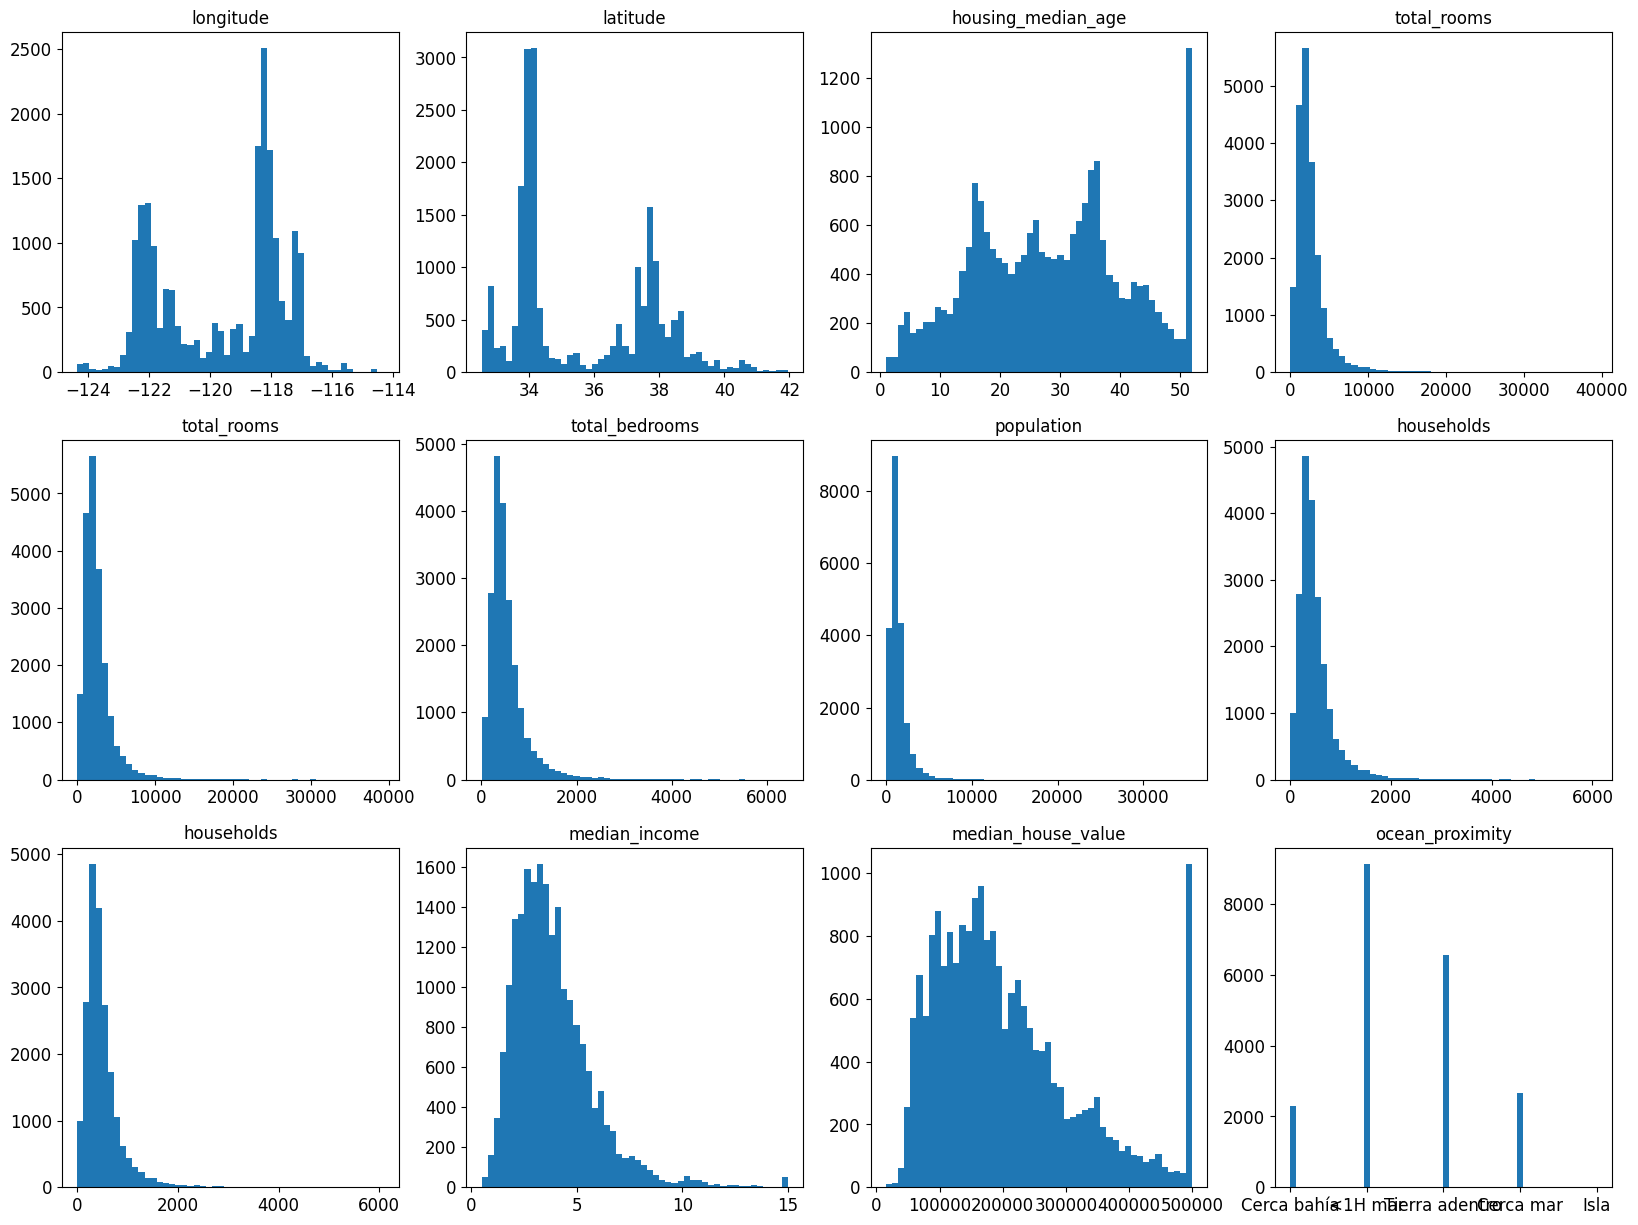

In [ ]:
df = housing

# Hacer histogramas de las feautures en `df`
columns = df.columns.to_list()

N_col = 4
N = len(columns)
N_rows = int(np.ceil(N/N_col))

fig, ax = plt.subplots(N_rows,N_col, figsize=(5*N_col,5*N_rows))

for i in range(N_rows):
    for j in range(N_col):
        ax[i,j].hist(df[columns[i*N_rows+j]], bins=50)
        ax[i,j].set_title(columns[i*N_rows+j])


**Hay algunas variables que parecen tener un exceso de valores en las colas de la distribución. ¿Cuáles son?**

Vamos a explorar más de cerca los valores máximos. Complete la celda de abajo con el nombre de las variables problemáticas.


In [ ]:
# Indicamos las columnas problematicas
problematic_columns = ['housing_median_age', 'median_income', 'median_house_value']

# Miremos esos valores máximos y cuántos datos caen allí
max_values=[]
for col in problematic_columns:
    max_value = housing[col].max()
    print(f"{col}: {sum(housing[col] == max_value)} distritos con {col} = {max_value} ({round(sum(housing[col] == max_value)/len(housing)*100,2)}%).")
    max_values.append(max_value)

housing_median_age: 1273 distritos con housing_median_age = 52 (6.17%).
median_income: 49 distritos con median_income = 15.0001 (0.24%).
median_house_value: 965 distritos con median_house_value = 500001 (4.68%).


¿Qué hacemos con los distritos con estos valores?
* ¿Los tenemos en cuenta?
* ¿Los ignoramos?

¿Los quitamos o los dejamos y tratamos de arreglarlos? Por simplicidad vamos a deshacernos de ellos. Pero por si acaso haremos una copia en una nueva variable del estado del dataset hasta este momento.

In [ ]:
# Copia del dataset
housing_clean = housing.copy()

# Para cada columna problemática, solo quedarse con las filas que contengan valoores diferentes a los máximos
for col, max_value in zip(problematic_columns, max_values):
    housing_clean = housing_clean[housing_clean[col] != max_value]

Veamos los histogramas de nuevo pero en el dataset limpio

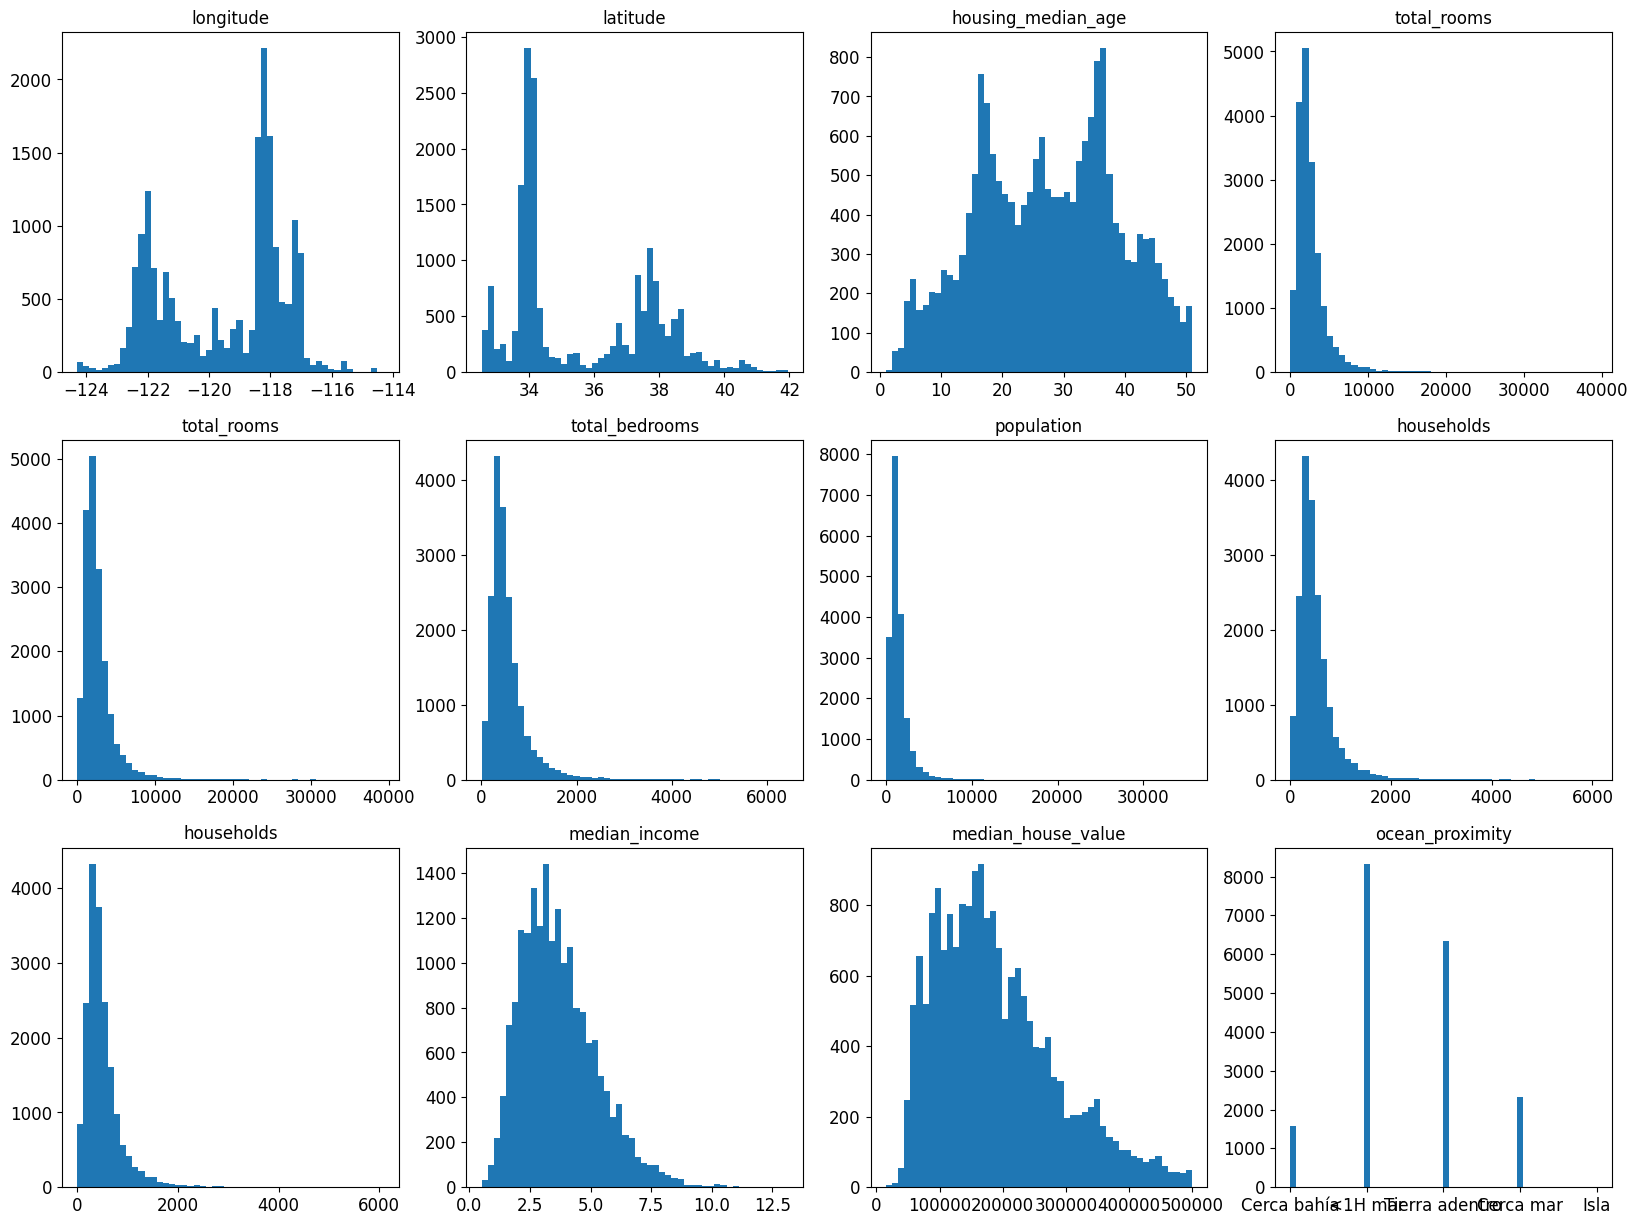

In [ ]:
df = housing_clean

#Plot histograms of the features in `df`
columns = df.columns.to_list()

N_col = 4
N = len(columns)
N_rows = int(np.ceil(N/N_col))

fig, ax = plt.subplots(N_rows,N_col, figsize=(5*N_col,5*N_rows))

for i in range(N_rows):
    for j in range(N_col):
        ax[i,j].hist(df[columns[i*N_rows+j]], bins=50)
        ax[i,j].set_title(columns[i*N_rows+j])


Como cambiamos el dataset repitamos el train/test split de antes

In [ ]:
target_column_name = 'median_house_value'
dataset = housing_clean
percentage = 0.2

X = dataset.drop(target_column_name, axis=1) # features
y = dataset[target_column_name] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percentage, random_state=42)

Aunque aquí no lo haremos, **a esta altura podríamos además tratar de eliminar todos los *outliers*** (datos cuyos valores se alejan demasiado del resto) de nuestra data. Algunos modelos pueden llegar a ser sensibles a este tipo de dato problemático, así que es algo que siempre debemos tener en cuenta.

### Valores faltantes

Si miramos cada atributo podremos observar que `total_bedrooms` tiene datos faltantes:

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18570 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           18570 non-null  float64
 1   latitude            18570 non-null  float64
 2   housing_median_age  18570 non-null  int64  
 3   total_rooms         18570 non-null  int64  
 4   total_bedrooms      18377 non-null  float64
 5   population          18570 non-null  int64  
 6   households          18570 non-null  int64  
 7   median_income       18570 non-null  float64
 8   ocean_proximity     18570 non-null  object 
dtypes: float64(4), int64(4), object(1)
memory usage: 1.4+ MB


Usemos el método `.isna()` de un `DataFrame` de Pandas para ver cuántos valores faltan.

In [ ]:
#let's see the NaN Values
X.isna()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False
15,False,False,False,False,False,False,False,False,False
18,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
20635,False,False,False,False,False,False,False,False,False
20636,False,False,False,False,False,False,False,False,False
20637,False,False,False,False,False,False,False,False,False
20638,False,False,False,False,False,False,False,False,False


La tabla de arriba no es muy útil. Sumemos los nulos de cada columna:

In [ ]:
#complete para calcular el porcentaje de faltantes de cada columna.
X.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        193
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

En general los modelos no manejan bien los valores faltantes, aunque hay excepciones.

Existen tres opciones para trabajar con nulos:
1. Excluir las variables con valores faltantes (es decir, eliminar columnas del dataset).
2. Excluir los registros con valores faltantes (es decir, eliminar filas del dataset).
3. Rellenar los datos faltantes de alguna manera (usar un modelo que prediga valores faltantes e imputar ese valor a los datos faltantes).

La elección óptima depende de la cantidad de los datos, de la importancia de la columna y de cuál es el proceso subyacente que genera valores nulos.

En este caso a modo ilustrativo vamos a tomar la opción 3 y rellenar los faltantes con la mediana del dataset de entrenamiento.


**Pregunta**. ¿Con qué valor podríamos rellenar los valores faltantes? Aquí vamos a usar la mediana, pero hay otras posibilidades.

In [ ]:
# Calculemos la mediana de las columnas faltantes
missing_data_column =['total_bedrooms']

#complete with the `.median()` method of the pandas series.
median = X_train[missing_data_column].median()

Ahora usaremos la mediana para rellenar tanto en el conjunto de entrenamiento como el de test. 

**IMPORTANTE**: hacer esta imputación de entrenamiento a test es correcta. Test sí puede "ver" al entrenamiento pero si usaramos el "test" para calcular la mediana y ponerla en entrenamiento estaríamos filtrando información.

Para esto, usamos el método `fillna` de Pandas.


In [ ]:
X_train[missing_data_column] = X_train[missing_data_column].fillna(median)

# Usamos la misma transformación en el Test, sin usar el training para preservar la objetividad
X_test[missing_data_column] = X_test[missing_data_column].fillna(median)

En el módulo `sklearn` van a encontrar muchas herramientas automáticas para hacer este preprocesado de datos. Por ejemplo, podemos usar el `SimpleImputer`:

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Para usar este SimpleImputer, tenemos que dejar de lado las variables categóricas,
# ya que sólo funciona con variables numéricas.
train_num = imputer.fit_transform(X_train.drop(['ocean_proximity'], axis=1))
test_num = imputer.transform(X_test.drop(['ocean_proximity'], axis=1))

### Variables categóricas

En su núcleo los algoritmos de ML procesan números. Por lo tanto se han inventado varias soluciones para poder mapear variables categóricas (texto,clases, colores) a variables númericas. En este dataset tenemos sólo una variable categoríca: Ocean proximity.

<1H mar           8329
Tierra adentro    6344
Cerca mar         2328
Cerca bahía       1567
Isla                 2
Name: ocean_proximity, dtype: int64

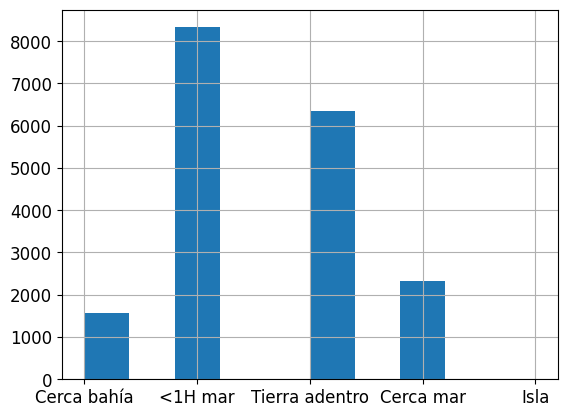

In [ ]:
X.ocean_proximity.hist()
X.ocean_proximity.value_counts()

Para pasar esta variable al modelo necesitamos "encodear" o codificar de alguna manera sus valores. Algunas maneras de hacer esto son:
* Asignar un número por categoría.
* Convertir cada categoría en una nueva variable binaria (que puede ser "on" y "off", 0 o 1)
* Aprender un mapeo útil de las categorías a un espacio multidimencional (conocido como *embedding*)

En la siguiente subsección usamos el `OneHotEncoder` de `sklearn` como ejemplo.

#### *One Hot Encoding

En la siguiente celda cargamos el `OneHotEncoder` de `sklearn` y se lo aplicamos a nuestros datos.

In [ ]:
#complete con los nombres de las variables categoricas/
categorical_columns= ['ocean_proximity']
cat_features = X_train[categorical_columns]

#Usaremos un OneHotEncoder.
from sklearn.preprocessing import OneHotEncoder

#instanciamos el codificador
cat_encoder = OneHotEncoder()

#Ajustamos a la data categorica
cat_encoder.fit(cat_features)

#lo usamos para transformar los datos categoricos. 
#si bien de "ajusto" con la data de entrenamiento, lo usamos para transformar los datos de Test
train_cat = cat_encoder.transform(X_train[categorical_columns]).toarray()
test_cat = cat_encoder.transform(X_test[categorical_columns]).toarray()

Para entender qué hace el encoder, imprimamos las variables antes y después de las transformación.

In [ ]:
print('Antes del encodeo:\n', X_train[categorical_columns][:6])

print('\nDespués del encodeo:\n', train_cat[:6])

Antes del encodeo:
       ocean_proximity
11431         <1H mar
10514         <1H mar
17117     Cerca bahía
11249         <1H mar
4299          <1H mar
10793         <1H mar

Después del encodeo:
 [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


Como habíamos visto con antes con el PCA, se puede usar el mismo objeto encoder para convertir la variable en un sentido y en el inverso usando los métodos `transform` e `inverse_transform`:

In [ ]:
for categorical_value in cat_features['ocean_proximity'].unique():
    print(f'{categorical_value:<14s}' + "-----> \t" + str(cat_encoder.transform([[categorical_value]]).toarray()[0]))

<1H mar       -----> 	[1. 0. 0. 0. 0.]
Cerca bahía   -----> 	[0. 1. 0. 0. 0.]
Tierra adentro-----> 	[0. 0. 0. 0. 1.]
Cerca mar     -----> 	[0. 0. 1. 0. 0.]
Isla          -----> 	[0. 0. 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(


O puede leerlo directamente de la matriz

In [ ]:
cat_encoder.inverse_transform([[1,0,0,0,0],
                               [0,1,0,0,0],
                               [0,0,1,0,0],
                               [0,0,0,1,0],
                               [0,0,0,0,1],])

array([['<1H mar'],
       ['Cerca bahía'],
       ['Cerca mar'],
       ['Isla'],
       ['Tierra adentro']], dtype=object)

### Standarisation (Feature Scaling)

Algunos modelos de ML no manejan bien las diferencias de escalas entre variables. En estos casos para hacer que el modelo converja más rápido (y a veces para garantizar algún tipo de convergencia), es útil cambiar la escala en la que se miden las variables o recentrarlas para que estén entre, por ejemplo, [0,1], o [-1,1] o para que esten centradas en cero y la varianza sea 1. En este notebook, vamos imaginar que el modelo que tenemos en mente requiere hacerlo.

Previamente rellenamos los `train_num` y `test_num`:

In [ ]:
print(train_num[:3])
print(test_num[:3])

[[-1.1796e+02  3.3670e+01  1.6000e+01  5.1430e+03  6.5200e+02  2.2090e+03
   6.3700e+02  7.0173e+00]
 [-1.1769e+02  3.3520e+01  3.0000e+00  7.3740e+03  1.4440e+03  3.2140e+03
   1.2790e+03  4.5380e+00]
 [-1.2216e+02  3.7480e+01  3.6000e+01  2.2380e+03  4.7900e+02  1.9490e+03
   4.5700e+02  2.3769e+00]]
[[-1.2120e+02  3.7780e+01  4.0000e+00  5.8000e+01  2.9000e+01  7.9000e+01
   2.9000e+01  3.3750e+00]
 [-1.1701e+02  3.2790e+01  3.1000e+01  3.7760e+03  8.1500e+02  1.8860e+03
   7.9900e+02  3.4421e+00]
 [-1.1969e+02  3.6830e+01  2.8000e+01  1.8680e+03  3.5000e+02  8.9800e+02
   3.2900e+02  3.1814e+00]]


Una opción es usar `StandardScaler`. Este operador restará la media del conjunto de entrenamiento y dividira por la varianza. De esta manera la nueva variable tendra media 0 y varianza 1.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Transformar el dataset numérico de train y test
train_num_scaled = scaler.fit_transform(train_num)
test_num_scaled = scaler.transform(test_num)

Veamos qué le pasa a los primeros registros de `train_num` y `train_num_scaled` para encontrar la diferencia.

In [ ]:
print(train_num[:3])
print(train_num_scaled[:3])

[[-1.1796e+02  3.3670e+01  1.6000e+01  5.1430e+03  6.5200e+02  2.2090e+03
   6.3700e+02  7.0173e+00]
 [-1.1769e+02  3.3520e+01  3.0000e+00  7.3740e+03  1.4440e+03  3.2140e+03
   1.2790e+03  4.5380e+00]
 [-1.2216e+02  3.7480e+01  3.6000e+01  2.2380e+03  4.7900e+02  1.9490e+03
   4.5700e+02  2.3769e+00]]
[[ 0.76963807 -0.89657589 -0.95701272  1.11361839  0.24409866  0.62730062
   0.32752307  2.13627369]
 [ 0.90577651 -0.96637832 -2.09285146  2.11818488  2.09198723  1.48347009
   1.97446694  0.54492148]
 [-1.34807099  0.87640573  0.7904315  -0.19443436 -0.15954367  0.40580404
  -0.13423689 -0.84219233]]


Podemos también comparar las medias y la desviación standard:

In [ ]:
print("Train before scaling:")
print(f"\t mean: {train_num.mean()}")
print(f"\t std: {train_num.std()}")

print("Train after scaling:")
print(f"\t mean: {train_num_scaled.mean()}")
print(f"\t std: {train_num_scaled.std()}")

Train before scaling:
	 mean: 643.2406034876482
	 std: 1284.9000222982963
Train after scaling:
	 mean: 2.9958683771656754e-16
	 std: 1.0


**Ejercicio.** Repitan lo mismo con el conjunto de test. 

In [ ]:
print("Test before scaling:")
print(f"\t mean: {...}")
print(f"\t std: {...}")

print("Test after scaling:")
print(f"\t mean: {...}")
print(f"\t std: {...}")

Test before scaling:
	 mean: Ellipsis
	 std: Ellipsis
Test after scaling:
	 mean: Ellipsis
	 std: Ellipsis


¿Notan algo distinto? ¿Por qué pasa esto?

## Juntando todo: Variables preparadas

Ahora que preparamos nuestras variables, podemos juntar todo, el escaleo, la imputación de nulos y la codificación de variables categorícas. Usemos la función `hstack` de numpy para juntar nuestras variables numéricas con las categóricas codificadas:

In [ ]:
X_train_final = np.hstack([train_num_scaled, train_cat])
X_test_final = np.hstack([test_num_scaled, test_cat])

Chequeamos que las formas se mantienen después de `hstack`. Remcordamos que cada fila es un registro.

In [ ]:
train_num_scaled.shape, train_cat.shape

((14856, 8), (14856, 5))

In [ ]:
X_train_final.shape

(14856, 13)

¡Muy bien! Ya tenemos nuestros datos listos para entrenar nuestro modelo. Resumamos todos los pasos que hicimos en el preprocesado de datos:



1.   Limpiar la data, removiendo datos problemáticos (en este caso por saturación) y outliers.
2.   Imputar/remover entradas con datos faltantes. 
3.   Normalizar/estandarizar variables numéricas.
4.   Codificar variables categóricas.



## Usando un primer modelo

A modo de ejemplo, vamos a ajustar un modelo lineal de `sklearn` para intentar predecir el *Median House Value*. Este va a ser tema de las clases siguientes, por ahora no nos preocuparemos de cómo funciona, sólo lo aplicaremos para justificar el preprocesado que hicimos.

Primero, ajusto el modelo

In [ ]:
from sklearn.linear_model import LinearRegression

# Creamos un modelo de regresión lineal
model = LinearRegression()

# Ajustamos el modelo con los datos de entrenamiento
model.fit(X_train_final, y_train)

LinearRegression()

y ahora lo voy "evaluar" usando los datos de testeo. Hagamos las prediciones de nuestro modelo, y comparemos con los valores reales:

In [ ]:
# Evaluo el modelo en los datos de test
test_preds = model.predict(X_test_final)

Como el input del modelo tiene muchas dimensiones, no podemos ponerlo en un gráfico lindo. Por ahora miremos sólo los primeros valores:

In [ ]:
print('*Median House Value*\n')
print(f'Modelo      Valor Real')
print(f'---------   ----------')
for i in range(10):
  print(f'{test_preds[i]:<10.2f}  {y_test.iloc[i]:<10.2f}')
print('etc...')

*Median House Value*

Modelo      Valor Real
---------   ----------
122679.69   106300.00 
215468.68   155300.00 
121442.38   78900.00  
105086.38   146900.00 
333819.23   286800.00 
266639.21   243200.00 
297220.78   275200.00 
232616.22   154800.00 
101543.29   96600.00  
195838.03   220700.00 
etc...


Más adelante aprenderemos a evaluar y cuantificar qué tan bueno es un modelo usando distintas métricas. ¡Pero eso ya sería adelantarnos!

## Lo que vimos hoy...

Hoy nos centramos en otra etapa de un proyecto de Machine Learning, el preprocesado de los datos. Tanto la extracción como la preparación y el preprocesado de los datos suelen ser de las tareas más arduas en ML. En este caso "tuvimos suerte" de que alguien ya nos había armado un dataset, pero en otros casos tal vez tengamos que nosotros mismo juntar datos de diversas fuentes y armar el dataset.

El preprocesado en sí de los datos va a *depender fuertemente del modelo* que vayamos a usar. En cada caso tendremos que adaptarnos a las exigencias particulares de lo que queremos hacer.

# Extras

### Stratified split
Esta sección es un poco más avanzada y pueden saltearla.
Aquí veremos qué hacer cuando queremos conseguir un conjunto de test que mantenga la proporción de ciertas variables que aparecen en el dataset general.

Esto se logra haciendo una partición estratificada o  _stratified split_.
Supongamos que queremos mantener la distribución de 'median_income'. Para ello definiremos bines de interés (algo análogo a grupos socio-económicos).

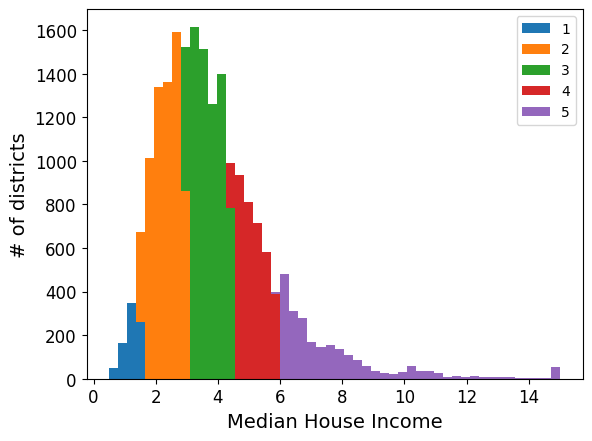

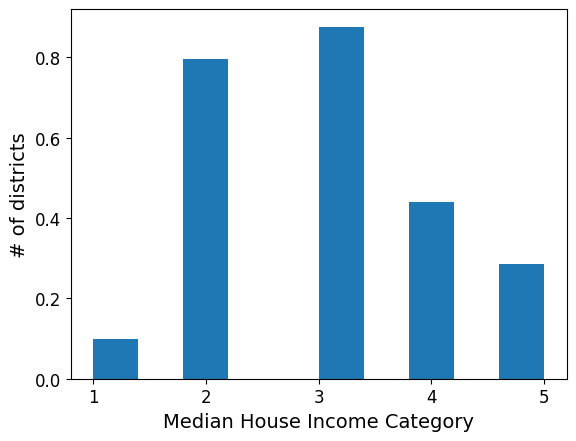

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [ ]:
housing_2 = housing.copy()
housing_2["income_cat"] = pd.cut(housing_2["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

plt.hist([housing_2[housing_2["income_cat"] == cat].median_income for cat in range(1,6)], 
         label =  list(range(1,6)), 
         bins=50,
         stacked=True)
plt.legend()
plt.ylabel('# of districts')
plt.xlabel('Median House Income')
plt.show()
plt.hist(housing_2['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.show()

housing_2['income_cat'].value_counts() / len(housing_2)

¿Que paso con la distribución? ¿Aumentó la de alguna clase en particular? ¿Cayó la de otra? ¿O se mantienen iguales?

Ahora hacemos un splitting al azar, como se hizo más arriba.

3    0.358527
2    0.324370
4    0.167393
5    0.109496
1    0.040213
Name: income_cat, dtype: float64

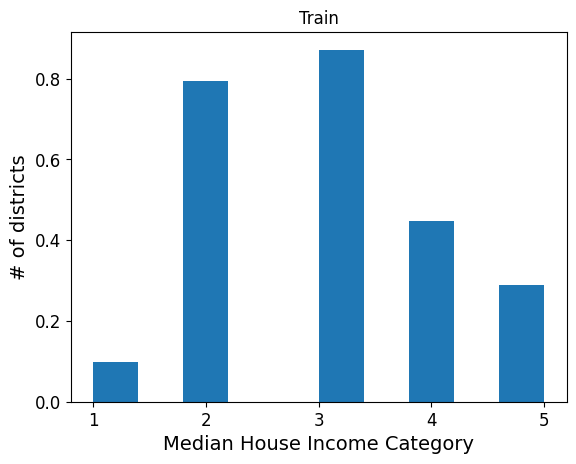

In [ ]:
train_df_2, test_df_2 = train_test_split(housing_2, test_size=0.2, random_state=42)

plt.hist(train_df_2['income_cat'], density=True)
plt.xticks([1,2,3,4,5])
plt.ylabel('# of districts')
plt.xlabel('Median House Income Category')
plt.title('Train')
test_df_2['income_cat'].value_counts() / len(test_df_2)

Cambio un poco... probemos ahora con `StratifiedShuffleSplit` de `sklearn` para preservar los porcentajes de cada categoría en la partición.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing_2, housing_2["income_cat"]):
    train_2 = housing_2.loc[train_index]
    test_2 = housing_2.loc[test_index]

print(f"Longitud del conjunto de entrenamiento: {len(train_2)}")
print(f"Longitud del conjunto de test: {len(test_2)}")

Longitud del conjunto de entrenamiento: 16512
Longitud del conjunto de test: 4128


In [ ]:
train_2['income_cat'].value_counts() / len(train_2)

3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: income_cat, dtype: float64

Esto luce mejor. Hagamos la siguiente comparación:

In [ ]:
comparison_df = pd.concat([housing_2['income_cat'].value_counts() / len(housing_2), test_df_2['income_cat'].value_counts() / len(test_df_2),test_2['income_cat'].value_counts() / len(test_2)], axis=1)
comparison_df.columns = ['original', 'random_split', 'stratified_split']
comparison_df

,original,random_split,stratified_split
3,0.350581,0.358527,0.350533
2,0.318847,0.324370,0.318798
4,0.176308,0.167393,0.176357
5,0.114438,0.109496,0.114341
1,0.039826,0.040213,0.039971


La diferencia puede parecer menor pero en datasets chicos hay más chances de tener *sesgo muestral* y que las distintas categorias no estén bien representadas en el conjunto de entrenamiento.